# **Uczenie Maszynowe - LAB2b - LIME**

Biblioteka LIME: https://github.com/marcotcr/lime (Dokumentacja API: https://lime-ml.readthedocs.io/en/latest/)

# **Wprowadzenie - pakiety**

Niezbędne pakiety i moduły na potrzeby wprowadzenia

In [5]:
import json
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
from lime import lime_image
from PIL import Image
from skimage.segmentation import mark_boundaries
from torchvision import models, transforms

ModuleNotFoundError: No module named 'torch'

# Wprowadzenie - funkcje pomocnicze

Funkcja do wczytywania wskazanego obrazka oraz konwersji do palety RGB.

In [2]:
def get_image(path):
    with open(path, "rb") as f:
        with Image.open(f) as img:
            return img.convert("RGB")

Funkcja do przekształcania obrazka (zwróconego przez funkcję `get_image`) w tensor, akceptowalny na wejściu sieci neronowej.

In [3]:
def image_to_tensor(img):
    transformer = transforms.Compose(
        [
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    return transformer(img).unsqueeze(0)

Funkcja używana przez LIME, przyjmuje na wejściu zbiór obrazków, a zwraca prawdopodobieństwa klas. Należy ją przekazać do `lime_image.LimeImageExplainer().explain_instance` przy użyciu `partial`, jako `partial(predict_batch, <model>)`, gdzie modelem w naszym wypadku będą sieci neuronowe. Przykłady użycia są zawarte w tym notebooku.

In [4]:
def predict_batch(model, images):
    model.eval()
    transformer = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    model.eval()
    batch = torch.stack(tuple(transformer(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probas = torch.nn.functional.softmax(logits, dim=1)
    return probas.detach().cpu().numpy()

Funkcja, która przekształca obrazek w format akceptowany na wejściu przez LIME. Przykłady użycia są zawarte w tym notebooku.

In [5]:
def lime_transformer(image):
    transformer = transforms.Compose(
        [transforms.Resize((256, 256)), transforms.CenterCrop(224)]
    )
    return np.array(transformer(image))

LIME jest głównie wykorzystywane do **wyjaśniania** predykcji tzw. czarnych skrzynek, czyli modeli nieinterpretowalnych. Idealnymi kandydatami są Głębokie Sieci Neuronowe, dlatego spróbujemy wyjaśnić niektóre predykcje gotowych modeli.

# **Model Inception-v3 - przygotowanie danych**
https://arxiv.org/abs/1512.00567

Plik `./data/imagenet_class_index.json` zawiera przypisanie klas obrazków do indeksów. Jest to istotne, ponieważ zwracane wyniki (np. wartości funkcji logit na wyjściu sieci neuronowych) wykorzystują to, zwracając wyniki w zadanej kolejności.

In [6]:
with open("./data/imagenet_class_index.json") as f:
    content = json.load(f)
    index_to_label = {int(index): data[1] for index, data in content.items()}

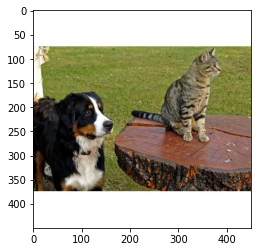

In [7]:
image_to_classify = get_image("./data/dogs.png")
plt.imshow(image_to_classify)

In [8]:
img_tensor = image_to_tensor(image_to_classify)

### **Załadowanie pretrenowanego modelu**

In [9]:
inception_v3 = models.inception_v3(pretrained=True)

### **Predykcja**

In [10]:
inception_v3.eval()
logits = inception_v3(img_tensor)

Zwróć uwagę, że model zwraca wartości funkcji logit, a nie prawdopodobieństwa klas, dlatego wyniki trzeba przetworzyć (np. przy użyciu funkcji softmax).

In [11]:
probas = torch.nn.functional.softmax(logits, dim=1)

Sprawdźmy N najbardziej prawdopodobnych klas

In [12]:
TOP_N_LABELS = 15

probas_top = probas.topk(TOP_N_LABELS)
top_probas = probas_top[0][0].detach().numpy()
top_labels = probas_top[1][0].detach().numpy()
for proba, label in zip(top_probas, top_labels):
    print(f"Class: {index_to_label[label]:<30} | Probability: {proba:.6f}")

Class: Bernese_mountain_dog           | Probability: 0.935930
Class: EntleBucher                    | Probability: 0.038448
Class: Appenzeller                    | Probability: 0.023756
Class: Greater_Swiss_Mountain_dog     | Probability: 0.001818
Class: Gordon_setter                  | Probability: 0.000009
Class: Blenheim_spaniel               | Probability: 0.000007
Class: English_springer               | Probability: 0.000002
Class: tabby                          | Probability: 0.000002
Class: robin                          | Probability: 0.000001
Class: guinea_pig                     | Probability: 0.000001
Class: amphibian                      | Probability: 0.000001
Class: Japanese_spaniel               | Probability: 0.000001
Class: African_grey                   | Probability: 0.000001
Class: Brittany_spaniel               | Probability: 0.000001
Class: toucan                         | Probability: 0.000001


### **Teraz możemy te funkcje zebrać razem**

In [13]:
def get_prediction_probabilities(image, model):
    img_tensor = image_to_tensor(image)
    model.eval()
    logits = model(img_tensor)
    probas = torch.nn.functional.softmax(logits, dim=1)

    TOP_N_LABELS = 15

    probas_top = probas.topk(TOP_N_LABELS)
    top_probas = probas_top[0][0].detach().numpy()
    top_labels = probas_top[1][0].detach().numpy()
    for proba, label in zip(top_probas, top_labels):
        print(f"Class: {index_to_label[label]:<30} | Probability: {proba:.6f}")

### **I sprawdzić jak ta predykcja wygląda dla innego obrazka**

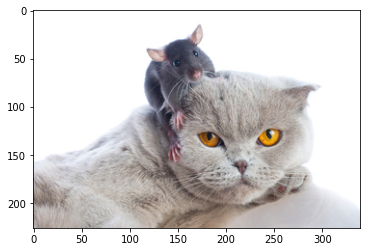

In [14]:
exercise_image = get_image("./data/cat_mouse.jpeg")
plt.imshow(exercise_image)

## **Zadanie: sprawdź jak będzie wyglądała predykcja dla powyższego obrazka**

In [15]:
# get_prediction_probabilities(here_insert_image, here_insert_model)

# **Model Inception-v3 - wyjaśnienie**

Chcemy wiedzieć dlaczego klasa `Bernese_mountain_dog` została uznana przez sieć neuronową za najbardziej prawdopodobną (to znaczy - które piksele obrazka o tym zadecydowały). W tym celu właśnie wykorzystamy LIME.

W jaki sposób działa LIME na obrazkach?
1. Na wejściu wymagany jest oryginalny obrazek.
2. Wejściowy obrazek jest delikatnie przekształcany wiele razy, dzięki czemu otrzymujemy wiele podobnych (ale nie takich samych!) obrazków.
3. Dodatkowo na wejście musimy podać funkcję, która każdemu takiemu przekształceniu nada prawdopodobieństwo przynależności do danej klasy. Jest to wymagane ponieważ LIME jest niezależny od żadnych narzędzi i modeli.

In [16]:
explainer = lime_image.LimeImageExplainer()

In [17]:
explanation = explainer.explain_instance(
    image=lime_transformer(image_to_classify),
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Mając te dane możemy teraz sprawdzić które kategorie są najbardziej prawdopodobne

In [18]:
for index in explanation.top_labels:
    print(index_to_label[index])

Bernese_mountain_dog
EntleBucher
Appenzeller
Greater_Swiss_Mountain_dog
Gordon_setter


Zobaczmy co wpłynęło na wybranie `Bernese_mountain_dog` jako najbardziej prawdopodobnej klasy.

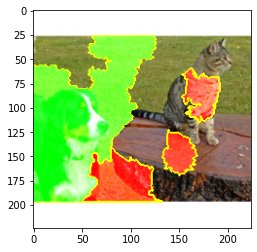

In [19]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False,
)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

## **Zadanie: zmień wartość NUM_FEATURES i zaobserwuj jak zmienia się mapowanie**
NUM_FEATURES najlepiej zmieniać w zakresie 1:50

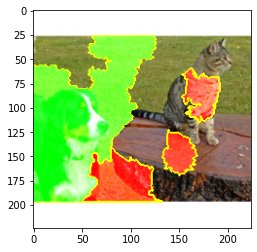

In [20]:
NUM_FEATURES = 10

image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=NUM_FEATURES,
    hide_rest=False,
)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Zielone fragmenty oznaczają "superpiksele", które pozytywnie wpływają na predykowaną klasę. Czerwone fragmenty wpływają negatywnie.

## **Zadanie-pytanie: co to właściwie jest superpiksel?**
## **Zadanie-pytanie: czy jeden superpiksel ma odzwierciedlenie w jednym pikselu z obrazka?**

Zobaczmy jak to się prezentuje dla drugiej najbardziej prawdopodobnej klasy, czyli `EntleBucher`, która jednak otrzymała jedyne 3.8%.

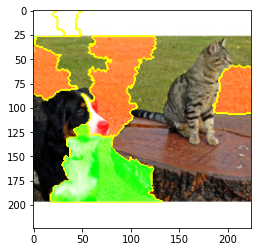

In [21]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[1],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False,
)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Ustawiając wartości `hide_rest` oraz `positive_only` na `True` jesteśmy w stanie zostawić tylko te piksele, które potwierdzały przynależność do danej klasy <br>
Musimy jednak pamiętać o przeskalowaniu rezultatu przy pomocy `(boundaries).astype(np.uint8)`

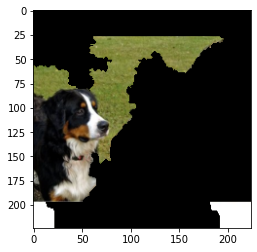

In [22]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    negative_only=False,
    num_features=10,
    hide_rest=True,
)
boundaries = mark_boundaries(image, mask)
plt.imshow((boundaries).astype(np.uint8))

Możemy również zostawić tylko te piksele, które zaprzeczały przynależności do danej klasy

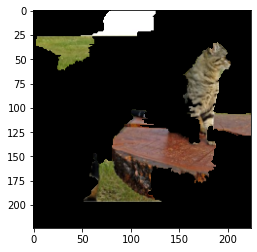

In [23]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=True,
    num_features=10,
    hide_rest=True,
)
boundaries = mark_boundaries(image, mask)
cropped_image_ndarray = (boundaries).astype(np.uint8)
plt.imshow(cropped_image_ndarray)

A następnie sprawdzić co model sądzi o tak wyciętym obrazku

In [24]:
cropped_image_pil = Image.fromarray(cropped_image_ndarray)

get_prediction_probabilities(cropped_image_pil, inception_v3)

Class: lumbermill                     | Probability: 0.404984
Class: chain_saw                      | Probability: 0.062897
Class: stupa                          | Probability: 0.053605
Class: altar                          | Probability: 0.043630
Class: candle                         | Probability: 0.042263
Class: groom                          | Probability: 0.033689
Class: pedestal                       | Probability: 0.030537
Class: torch                          | Probability: 0.023751
Class: hatchet                        | Probability: 0.015875
Class: cannon                         | Probability: 0.009360
Class: plane                          | Probability: 0.009040
Class: mortarboard                    | Probability: 0.008965
Class: komondor                       | Probability: 0.007631
Class: swab                           | Probability: 0.006665
Class: collie                         | Probability: 0.006336


I jak go teraz widzi model

In [25]:
cropped_image_explanation = explainer.explain_instance(
    image=lime_transformer(cropped_image_pil),
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

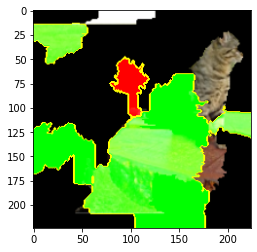

In [26]:
image, mask = cropped_image_explanation.get_image_and_mask(
    label=cropped_image_explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False,
)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

# **Model Inception-v3 - porównanie z AlexNet**

Przetestujmy działanie na innym modelu - `AlexNet`

In [27]:
alexnet = models.alexnet(pretrained=True)

In [28]:
explanation_alexnet = explainer.explain_instance(
    image=lime_transformer(image_to_classify),
    classifier_fn=partial(predict_batch, alexnet),
    top_labels=5,
    num_samples=1000,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [29]:
for index_alex, index_inception in zip(
    explanation_alexnet.top_labels, explanation.top_labels
):
    print(f"{index_to_label[index_alex]:30} | {index_to_label[index_inception]:30}")

Bernese_mountain_dog           | Bernese_mountain_dog          
EntleBucher                    | EntleBucher                   
Greater_Swiss_Mountain_dog     | Appenzeller                   
Appenzeller                    | Greater_Swiss_Mountain_dog    
basset                         | Gordon_setter                 


Jak widać, klasy nieco się różnią, ale TOP 1 pozostaje takie samo.

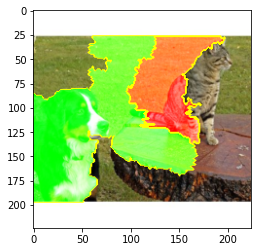

In [30]:
image, mask = explanation_alexnet.get_image_and_mask(
    label=explanation_alexnet.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False,
)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Wyjaśnienie dla `AlexNet` jak się można było spodziewać - też się różni, jednak w dalszym ciągu do klasyfikacji psa istotny jest... pies :)

## **Zadanie: porównaj predykcje obrazka dla modeli inception_v3 oraz alexnet**

In [31]:
print("inception_v3")
# get_prediction_probabilities(image_to_classify, here_insert_model)
print()
print("alexnet")
# get_prediction_probabilities(image_to_classify, here_insert_model)

inception_v3

alexnet


# **Zadanie domowe - wstęp**
W folderze `data` znajduje się zdjęcie amfibii:
![title](data/amfibia.jpg)


In [32]:
amphibious_vehicle = get_image("./data/amfibia.jpg")

  0%|          | 0/1000 [00:00<?, ?it/s]

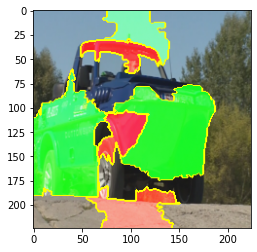

In [33]:
inception_v3 = models.inception_v3(pretrained=True)

explanation_amhibious_vehicle_inception_v3 = explainer.explain_instance(
    image=lime_transformer(amphibious_vehicle),
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000,
)

image, mask = explanation_amhibious_vehicle_inception_v3.get_image_and_mask(
    label=explanation_amhibious_vehicle_inception_v3.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False,
)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Model `inception_v3` jak i jego wyjaśnienie rzeczywiście sugerują amfibię jako najbardziej prawdopodobną klasę:

In [34]:
for index in explanation_amhibious_vehicle_inception_v3.top_labels:
    print(index_to_label[index])

amphibian
convertible
racer
car_wheel
golfcart


# Zadanie #1

Użyj dwóch różnych sieci neuronowych (poza inception_v3, którego przykład jest powyżej) do wygenerowania wyjaśnień.<br>
(skorzystaj z modułu torchvision: https://pytorch.org/vision/stable/models.html)

# Zadanie #2

Zmodyfikuj oryginalny obrazek w taki sposób, żeby najbardziej prawdopodobną klasą dla każdej z tych sieci **nie była** amfibia a jakiś inny pojazd (np. samochód). W tym celu możesz "zasłonić" czarnym kwadratem (wartość 0 w macierzy reprezentującej obraz) obszary istotne przy klasyfikacji. <br>
Przydatną rzeczą będzie skorzystanie z opcji `hide_rest` w funkcji `get_image_and_mask` i późniejsza obróbka obrazu

# Zadanie #3

Ponownie zmodyfikuj oryginalny obraz, ale tym razem zaszumiając go w losowy sposób (przykładowa implementacja: https://www.geeksforgeeks.org/add-a-salt-and-pepper-noise-to-an-image-with-python/). Czy najbardziej prawdopodobna klasa zmienia się wraz ze zmianą szumu? Przetestuj dla każdego z modeli.